In [ ]:
!pip install imbalanced-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("dataset_binary.csv")

print("Shape:", df.shape)
print("\nTarget Distribution:\n", df["Diabetes_binary"].value_counts())

df.head()

Shape: (253680, 22)

Target Distribution:
 Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
df = df.drop(columns=["Stroke", "HeartDiseaseorAttack"], errors='ignore')
df.drop_duplicates(inplace=True)

X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
sm = SMOTE(random_state=42)

print("Before SMOTE:", np.bincount(y_train))
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_sm))

Before SMOTE: [154380  27990]
After SMOTE: [154380 154380]


In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

lr.fit(X_train_sm, y_train_sm)

y_probs_lr = lr.predict_proba(X_test)[:, 1]

In [ ]:
# Class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(weights))

ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sm.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

ann.fit(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

y_probs_ann = ann.predict(X_test).ravel()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.5800 - loss: 0.7453 - val_accuracy: 0.9601 - val_loss: 0.1864
Epoch 2/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6177 - loss: 0.6599 - val_accuracy: 0.9605 - val_loss: 0.1937
Epoch 3/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6226 - loss: 0.6492 - val_accuracy: 0.9635 - val_loss: 0.1871
Epoch 4/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6276 - loss: 0.6449 - val_accuracy: 0.9655 - val_loss: 0.1886
Epoch 5/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6230 - loss: 0.6454 - val_accuracy: 0.9653 - val_loss: 0.1891
Epoch 6/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6217 - loss: 0.6441 - val_accuracy: 0.9630 - val_loss: 0.1840
Epoch 7/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6240 - loss: 0.6400 - val_accuracy: 0.9672 - val_loss: 0.1713
Epoch 8/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6235 - loss: 0

In [ ]:
def find_best_threshold(y_true, y_probs):
    best_t = 0
    best_f1 = 0

    for t in np.arange(0.1, 0.9, 0.02):
        y_pred = (y_probs > t).astype(int)

        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

In [ ]:
best_t_lr = find_best_threshold(y_test, y_probs_lr)
best_t_ann = find_best_threshold(y_test, y_probs_ann)

print("Best LR Threshold:", best_t_lr)
print("Best ANN Threshold:", best_t_ann)

Best LR Threshold: 0.5800000000000001
Best ANN Threshold: 0.8600000000000001


In [ ]:
y_pred_lr = (y_probs_lr > best_t_lr).astype(int)
y_pred_ann = (y_probs_ann > best_t_ann).astype(int)

In [ ]:
def evaluate(name, y_true, y_pred, y_probs):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_probs))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate("Logistic Regression (Final)", y_test, y_pred_lr, y_probs_lr)
evaluate("ANN (Final)", y_test, y_pred_ann, y_probs_ann)


Logistic Regression (Final)
Accuracy: 0.7651393854319742
Precision: 0.35572661534872874
Recall: 0.653851650707446
F1: 0.46077147749018027
AUC: 0.8068389239644671
Confusion Matrix:
 [[30310  8286]
 [ 2422  4575]]

ANN (Final)
Accuracy: 0.7794836926721207
Precision: 0.3707618161833094
Recall: 0.6266971559239675
F1: 0.46589460263493415
AUC: 0.8119910050430539
Confusion Matrix:
 [[31154  7442]
 [ 2612  4385]]


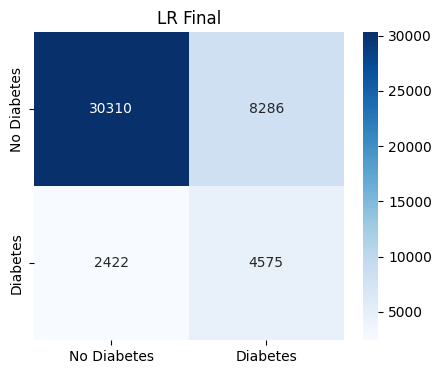

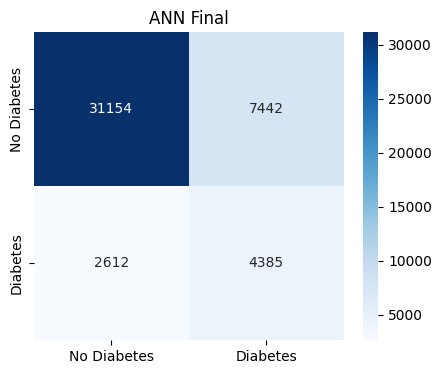

In [ ]:
def plot_cm(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    plt.title(title)
    plt.show()

plot_cm(confusion_matrix(y_test, y_pred_lr), "LR Final")
plot_cm(confusion_matrix(y_test, y_pred_ann), "ANN Final")

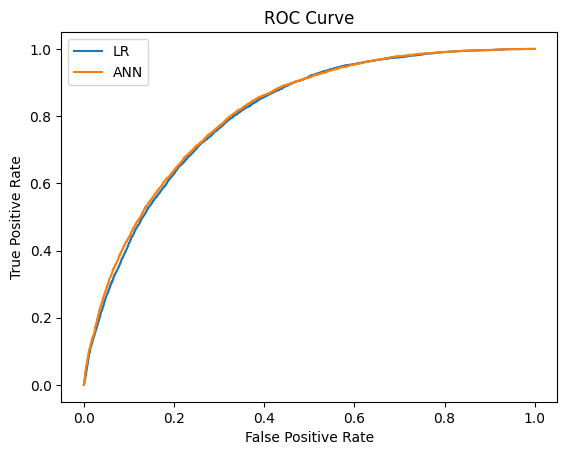

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_probs_ann)

plt.plot(fpr_lr, tpr_lr, label="LR")
plt.plot(fpr_ann, tpr_ann, label="ANN")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

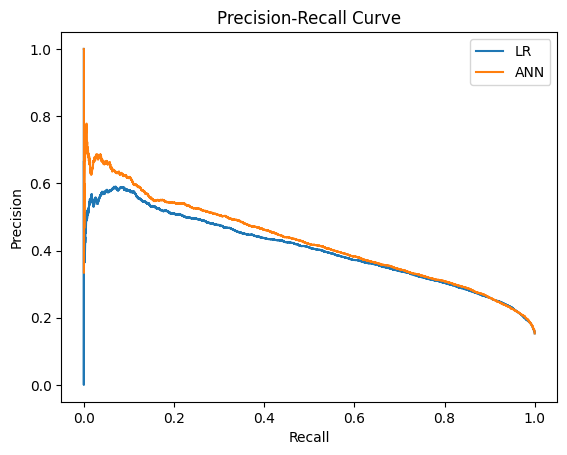

In [ ]:
p_lr, r_lr, _ = precision_recall_curve(y_test, y_probs_lr)
p_ann, r_ann, _ = precision_recall_curve(y_test, y_probs_ann)

plt.plot(r_lr, p_lr, label="LR")
plt.plot(r_ann, p_ann, label="ANN")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()